# Pyjive workshop: Applying constraints

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download additional files (if necessary)

import contextlib
import os
from urllib.request import urlretrieve

def findfile(fname):
    url = "https://gitlab.tudelft.nl/cm/public/drive/-/raw/main/constraints/" + fname + "?inline=false"
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve(url, fname)

findfile("kmatrix.py")

## Problem statement

Consider the following 1-element problem composed of a single linear quadrilateral (Q4 or Quad4) element:

<center><img src="https://raw.githubusercontent.com/ibcmrocha/public/main/oneelem_square.png" alt="beam" width="400"/></center>

where you can also see several of the DOFs are constrained to either zero or non-zero values (Dirichlet constraints).

Using the correct shape functions $\mathbf{N}$ and encapsulating our kinematic assumptions in $\mathbf{B}$, we can use numerical integration to compute the stiffness matrix of this element. The resulting values are:

$$\mathbf{K}^e=\dfrac{1}{364}\begin{bmatrix}
 180 &   65 & -110 &   -5 &  -90 &  -65 &   20 &    5 \\
  65 &  180 &    5 &   20 &  -65 &  -90 &   -5 & -110 \\
-110 &    5 &  180 &  -65 &   20 &   -5 &  -90 &   65 \\
  -5 &   20 &  -65 &  180 &    5 & -110 &   65 &  -90 \\
 -90 &  -65 &   20 &    5 &  180 &   65 & -110 &   -5 \\
 -65 &  -90 &   -5 & -110 &   65 &  180 &    5 &   20 \\
  20 &   -5 &  -90 &   65 & -110 &    5 &  180 &  -65 \\
   5 & -110 &   65 &  -90 &   -5 &   20 &  -65 &  180 
\end{bmatrix}
%, \mathbf{a}^e = \myMat{a_{1x}\\a_{1y}\\a_{2x}\\a_{2y}\\a_{3x}\\a_{3y}\\a_{4x}\\a_{4y}}
$$

which is in this single element model also the global stiffness matrix.

Now recall we would like to use this matrix to solve for $\mathbf{u}$:

$$\mathbf{u}=\mathbf{K}^{-1}\mathbf{f}$$

which means $\mathbf{K}$ should be invertible.

In the block below, try to directly invert $\mathbf{K}$ using `np.linalg.inv()`. You can also try to multiply $\mathbf{K}^{-1}$ by a force vector, say one containing some small Gaussian noise:


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1: Invert the matrix</b>   

- Complete the code block below to invert $\mathbf{K}$ and solve $\mathbf{Ku}=\mathbf{f}$ with a random force vector with small numbers. 
- What do you observe for the values in $\mathbf{K}^{-1}$ and $\mathbf{u}$?
</p>
</div>


In [17]:
from kmatrix import K

# try to invert K here
K_inv = np.linalg.inv(K)
# print("Inverse of K:\n", K_inv)

random_f = np.random.normal(scale=0.1,size=8)

# try to solve for u here
u = np.linalg.solve(K, random_f)
print("u:\n", u)

u:
 [ 2.89366680e+15 -2.77720496e+14  2.89366680e+15  6.09945404e+14
  2.00600090e+15  6.09945404e+14  2.00600090e+15 -2.77720496e+14]


## Introducing constraints

There is clearly something missing in the model above. The huge matrix entries in $\mathbf{K}^{-1}$ are a telltale sign of an (almost) singular matrix. This also makes physical sense: For now, this is a Q4 element floating in space. In order for a unique equilibrium to exist for any external force, we have to introduce supports.

To demonstrate how Dirichlet boundary conditions are applied in pyJive, we copy here parts of the `Constrainer` class that can be found in `utils/constrainer.py`:

In [13]:
class Constrainer:
    def __init__(self):
        self._dofs = []
        self._vals = []

    def add_constraint(self, dof, val):
        self._dofs.append(dof)
        self._vals.append(val)

    def constrain(self, k, f):
        kc = np.copy(k)
        fc = np.copy(f)

        for dof, val in zip(self._dofs, self._vals):
            for i in range(kc.shape[0]):
                if i == dof:
                    fc[i] = val
                else:
                    fc[i] -= kc[i, dof] * val

            kc[:, dof] = kc[dof, :] = 0.0
            kc[dof, dof] = 1.0

        return kc, fc

We now use the `Constrainer` to apply our BCs.

For assembling the element stiffness matrix $\mathbf{K}$, we implicitly assumed the following DOF order:

$$\mathbf{a}=\begin{bmatrix}
a_{1x}\\
a_{1y}\\
a_{2x}\\
a_{2y}\\
a_{3x}\\
a_{3y}\\
a_{4x}\\
a_{4y}\\
\end{bmatrix}$$

That means our constraints look like:

| Node | Direction | DOF index | Value |
|---|---|---|---|
|1|$x$|0|0|
|1|$y$|1|0|
|2|$x$|2|1|
|2|$y$|3|0|
|3|$x$|4|1|
|4|$x$|6|0|

In the full code, we do not need to manually keep track of DOF indices. This bookkeeping is taken care of by the `DofSpace` class, and to retrieve a DOF index we only need to know the node index and the DOF direction.

For simplicity, we do it manually here.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2: Constrain the problem </b>   

- Use the code block below to tell the constrainer class what constraints are there for this problem 
- Run the following blocks to construct and inspect the constrained stiffness matrix and force vector
    
</p>
</div>

In [26]:
con = Constrainer()

con.add_constraint(0, 1)
con.add_constraint(1, 1)
con.add_constraint(2, 1)
con.add_constraint(3, 1)
# ...
# con.add_constraint(???,???)
# ...

The `constrainer` instance is now ready to give us the constrained matrix:

In [31]:
f = np.zeros(8)
Kc, fc = con.constrain(K, f)

We can take a look inside:

In [32]:
print('Constrained matrix\n',Kc)
print('Constrained force\n',fc)

Constrained matrix
 [[ 1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.49450549  0.17857143
  -0.3021978  -0.01373626]
 [ 0.          0.          0.          0.          0.17857143  0.49450549
   0.01373626  0.05494505]
 [ 0.          0.          0.          0.         -0.3021978   0.01373626
   0.49450549 -0.17857143]
 [ 0.          0.          0.          0.         -0.01373626  0.05494505
  -0.17857143  0.49450549]]
Constrained force
 [1.         1.         1.         1.         0.35714286 0.74175824
 0.02747253 0.35714286]


Or have a qualitative look by plotting them:

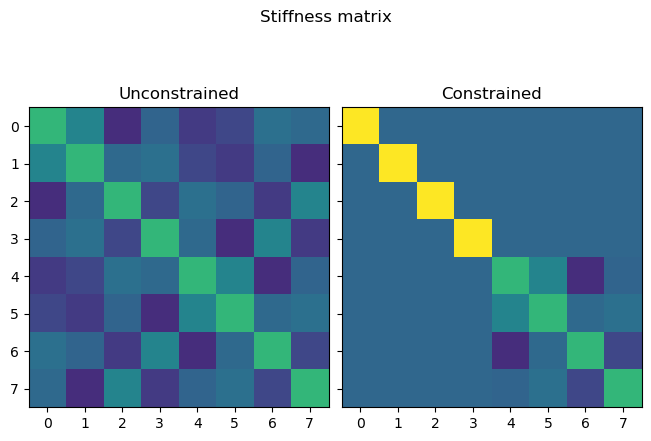

In [33]:
fig = plt.figure(constrained_layout=True)

fig.suptitle('Stiffness matrix')
axs = fig.subplots(1, 2, sharey=True)
axs[0].imshow(K,vmin=-0.5,vmax=1)
axs[0].set_title('Unconstrained')
axs[0].set_xticks(range(0,8))
axs[1].imshow(Kc,vmin=-0.5,vmax=1)
axs[1].set_title('Constrained')
axs[1].set_xticks(range(0,8))

[]

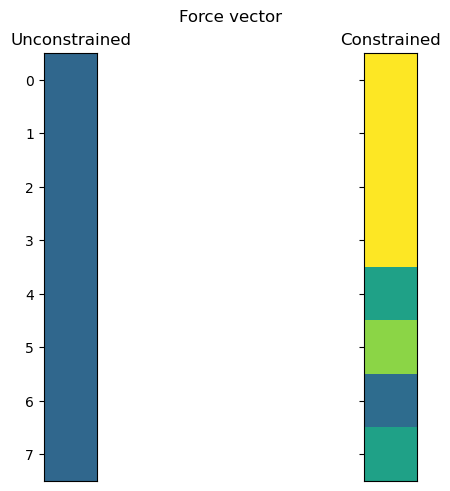

In [30]:
fig = plt.figure(constrained_layout=True)

fig.suptitle('Force vector')
axs = fig.subplots(1, 2, sharey=True)
axs[0].imshow(f.reshape((8,1)),vmin=-0.5,vmax=1)
axs[0].set_title('Unconstrained')
axs[0].set_xticks([])
axs[1].imshow(fc.reshape((8,1)),vmin=-0.5,vmax=1)
axs[1].set_title('Constrained')
axs[1].set_xticks([])

Note that here we use the size-preserving approach, with `1` entries on the diagonal of the constrained DOFs. We also keep the symmetry of $\mathbf{K}$ by moving some terms to the right-hand side of the system.

## Solving the system

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3: Solve the constrained problem</b>   

- Use the code block below to solve the constrained system of equations
- Does the solution satisfy the constraints?
- What are the values of the displacements that were unknown in this problem?
- Are these displacement values in line with expectations? 
    
</p>
</div>

Instead of storing it as a sparse matrix and solving the system (contrast it to how we do it in `SolverModule`), here we just invert it and multiply by $\mathbf{f}$ for simplicity:

In [34]:
u = np.matmul(np.linalg.inv(Kc),fc)
print('Nodal displacements:',u)

Nodal displacements: [1. 1. 1. 1. 1. 1. 1. 1.]



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4: Compute support reactions</b>   

- Partition matrix and vector in free (`f`) and constrained (`c`) parts, using information from the `Constrainer` on which DOFs are constrained. 
    
- Code an expression that gives the reaction forces on constrained DOFs.
    
- Do the results make sense for the given problem? 

</p>
</div>


In [35]:
cdofs = con._dofs
fdofs = [i for i in range(len(K)) if i not in cdofs]

# kcf = K[np.ix_(???,???)]
# kcc = K[np.ix_(???,???)]

# uc  = u[???]
# uf  = u[???]

# reactions = ???
print('Support reactions:',reactions)

NameError: name 'reactions' is not defined


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5: Explore the `pyjive` source code</b>   

- Check whether the functions in the `Constrainer` are indeed the same as given below (see `utils/constrainer.py`)
- From which place in the code is the `add_constraint` function called?
- From which place in the code is the `constrain` function called?

</p>
</div>
